**CURSO**: *Machine Learning* en Geociencias<br />
**Profesor**: Edier Aristizábal (evaristizabalg@unal.edu.co) <br />
**Credits**: The content of this notebook is taken from [Rens van de Schoot](https://www.rensvandeschoot.com/tutorials/lme4) del libro Multilevel Analysis: Techniques and applications.

In [ ]:
install.packages("sjstats")

In [ ]:
oo <- options(repos = "https://cran.r-project.org/")
install.packages("ggmcmc")
options(oo)

# Hierarchical Regression Models con brms

A continuación se presenta un ejemplo de características de estudiantes en diferentes clases. Para un mayor detalle se recomienda leer el [Cap 2](https://www.rensvandeschoot.com/wp-content/uploads/2017/09/02Ch2-Basic.pdf).

In [ ]:
library(brms) # for the analysis
library(lme4) # for the analysis
library(haven) # to load the SPSS .sav file
library(tidyverse) # needed for data manipulation.
library(RColorBrewer) # needed for some extra colours in one of the graphs
library(ggmcmc)
library(ggthemes)
library(ggridges)

In [7]:
popular2data <- read_sav(file = "https://github.com/MultiLevelAnalysis/Datasets-third-edition-Multilevel-book/blob/master/chapter%202/popularity/SPSS/popular2.sav?raw=true")

De la base de datos se seleccionan las variables a utilizar.

In [8]:
popular2data <- select(popular2data, pupil, class, extrav, sex, texp, popular) # we select just the variables we will use
head(popular2data) # we have a look at the first 6 observations

pupil,class,extrav,sex,texp,popular
<dbl>,<dbl>,<dbl>,<dbl+lbl>,<dbl>,<dbl>
1,1,5,1,24,6.3
2,1,7,0,24,4.9
3,1,4,1,24,5.3
4,1,3,1,24,4.7
5,1,5,1,24,6.0
6,1,4,0,24,4.7


A continuación se grafican los datos.

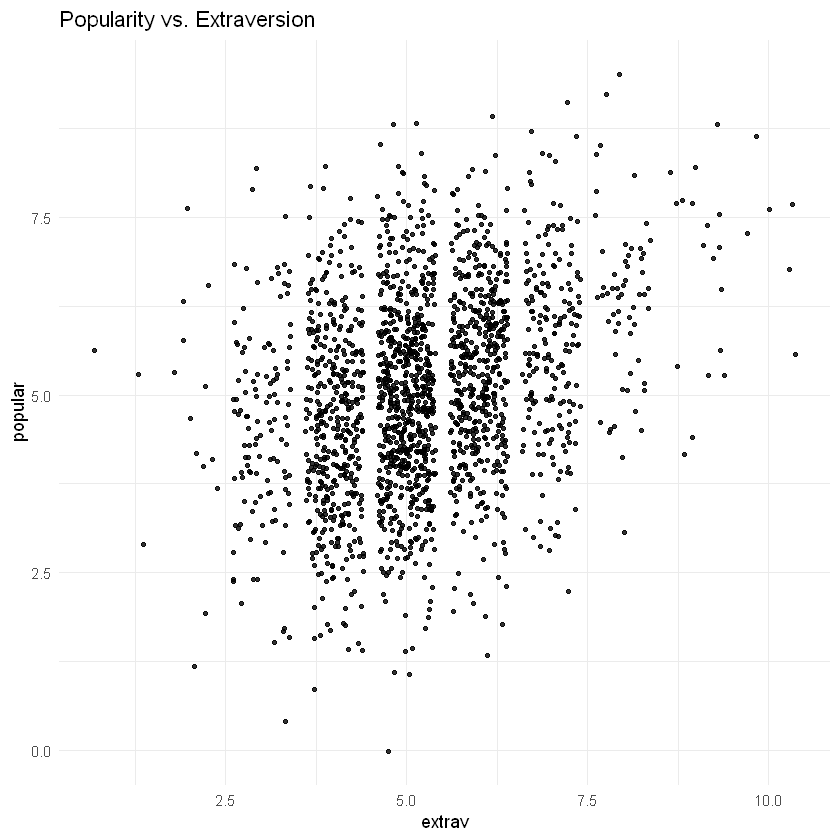

In [28]:
ggplot(data  = popular2data,aes(x = extrav,y = popular))+
    geom_point(size = 1.2,alpha = .8,position = "jitter")+ # to add some random noise for plotting purposes
    theme_minimal()+
    labs(title = "Popularity vs. Extraversion")

Ahora adicionamos una línea de ajuste a los datos.

`geom_smooth()` using formula = 'y ~ x'


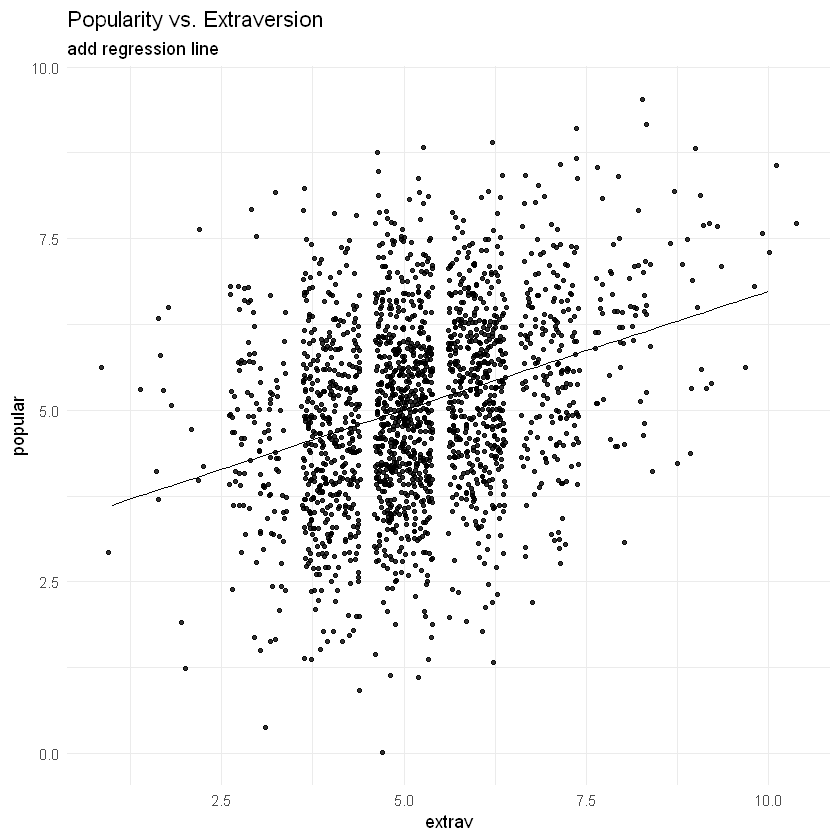

In [29]:
ggplot(data=popular2data,aes(x=extrav,y=popular))+
  geom_point(size=1.2,alpha=.8,position="jitter")+ #to add some random noise for plotting purposes
  geom_smooth(method = lm,se= FALSE,col= "black",size=.5,alpha=.8)+ # to add regression line
  theme_minimal()+
  labs(title= "Popularity vs. Extraversion",subtitle = "add regression line")

De esta foram se ignora la estructura multiniveles que presentan los datos. La cual se puede evidenciar incorporando en la gráfica las diferentes clases a los cuales pertenecen los estudiantes

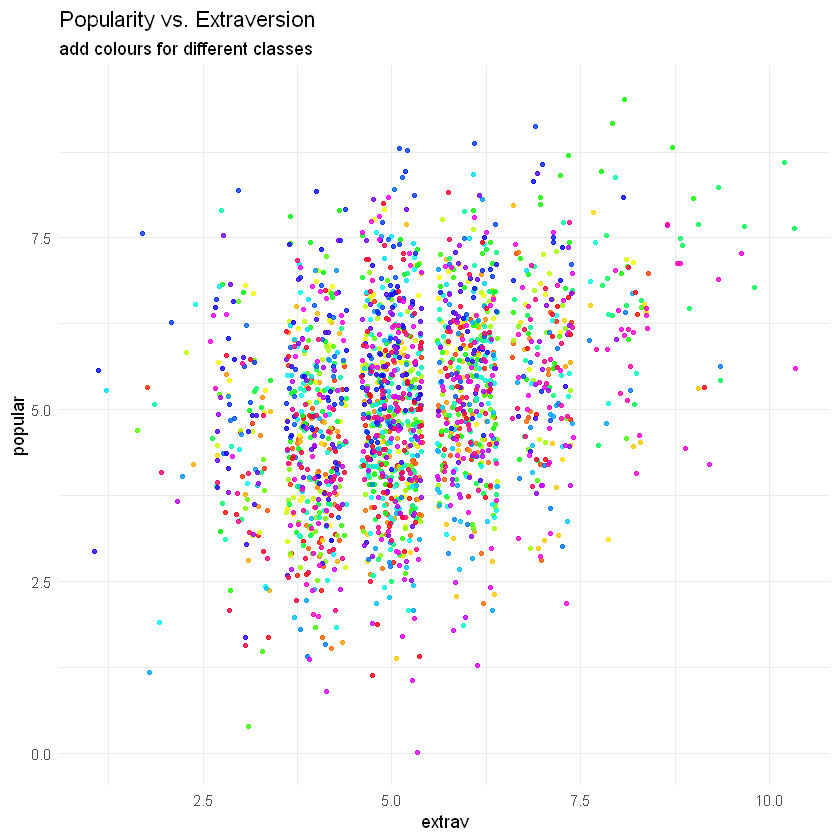

In [30]:
ggplot(data=popular2data,aes(x=extrav,y=popular,col = class))+ #to add the colours for different classes
  geom_point(size=1.2,alpha=.8,position="jitter")+ #to add some random noise for plotting purposes
  theme_minimal()+
  theme(legend.position = "none")+
  scale_color_gradientn(colours = rainbow(100))+
  labs(title    = "Popularity vs. Extraversion",subtitle = "add colours for different classes")

Y se puede ajustar una linea para cada clase.

`geom_smooth()` using formula = 'y ~ x'


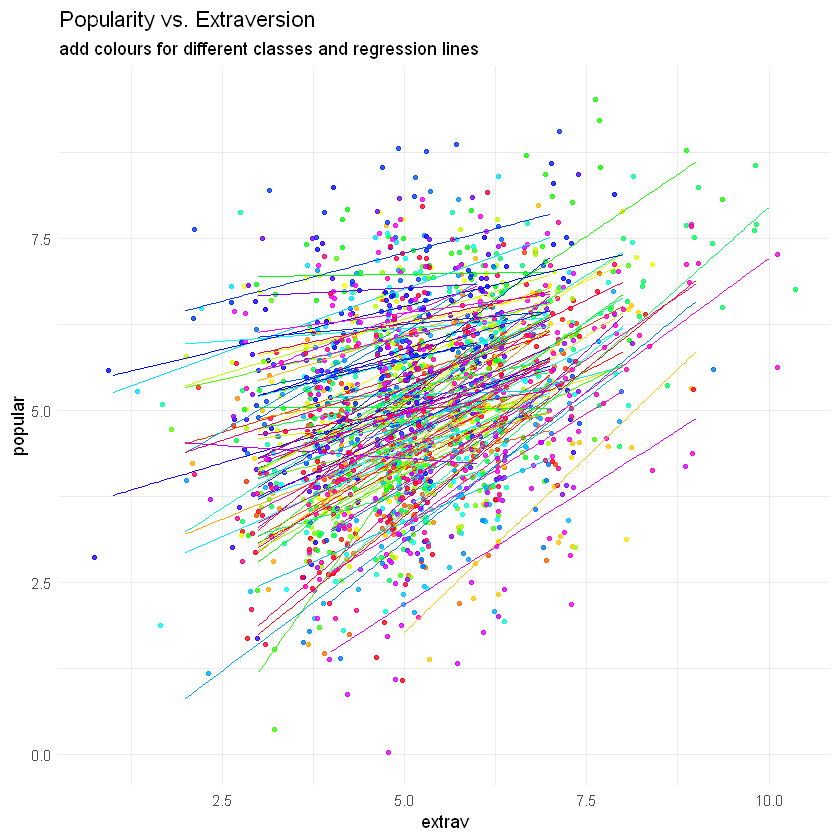

In [31]:
ggplot(data=popular2data,aes(x=extrav,y=popular,col=class,group=class))+ #to add the colours for different classes
  geom_point(size=1.2,alpha=.8,position="jitter")+ #to add some random noise for plotting purposes
  theme_minimal()+
  theme(legend.position="none")+
  scale_color_gradientn(colours=rainbow(100))+
  geom_smooth(method=lm,se=FALSE,size=.5,alpha=.8)+ # to add regression line
  labs(title="Popularity vs. Extraversion",subtitle="add colours for different classes and regression lines")

Los resultados muestran que la pendiente de la relación lineal cambia, es decir que los cambios no son iguales para todas las clases. A continuación se presenta una función para identificar las tendencias extremo.

In [4]:
# To colour code the extremes, we need to write a small function that calculates the regression lines and adds a collumn indicating which clusters have the most extreme.
f1 <- function(data, x, y, grouping, n.highest = 3, n.lowest = 3){
  groupinglevel <- data[,grouping]
  res           <- data.frame(coef = rep(NA, length(unique(groupinglevel))), group = unique(groupinglevel))
  names(res)    <- c("coef", grouping)
  for(i in 1:length(unique(groupinglevel))){
    data2    <- as.data.frame(data[data[,grouping] == i,])
    res[i,1] <- as.numeric(lm(data2[, y] ~ data2[, x])$coefficients[2])
  }
  top    <- res %>% top_n(n.highest, coef)
  bottom <- res %>% top_n(-n.lowest, coef)
  res    <- res %>% mutate(high_and_low = ifelse(coef %in% top$coef, "top",  ifelse(coef %in% bottom$coef, "bottom", "none")))
  data3  <- left_join(data, res)
  return(data3)
}

Joining with `by = join_by(class)`
Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead."
`geom_smooth()` using formula = 'y ~ x'


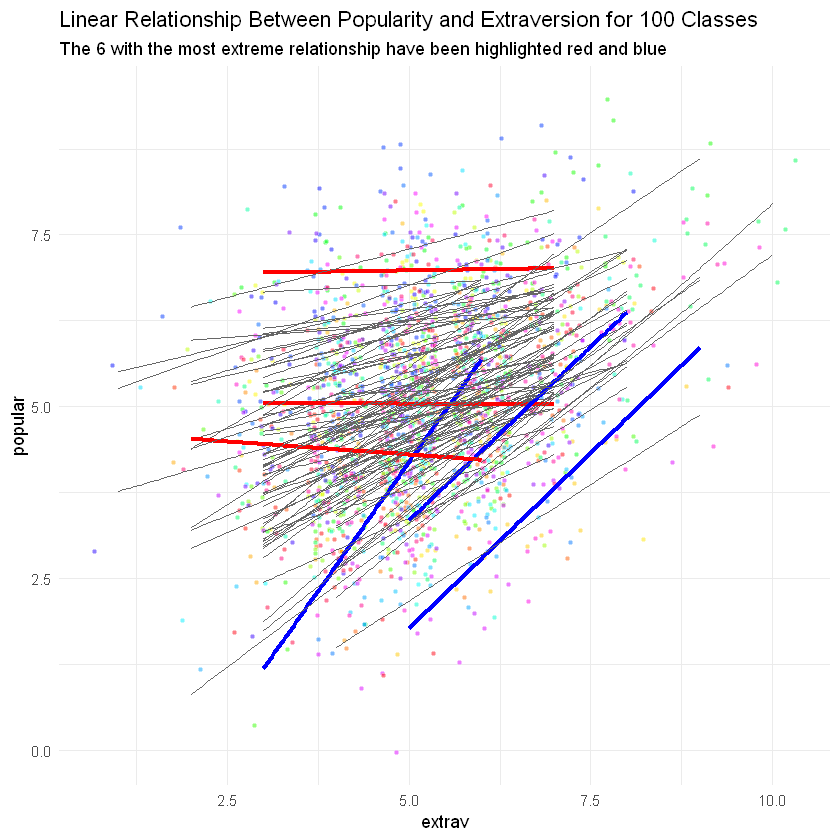

In [5]:
f1(data = as.data.frame(popular2data),x="extrav",y="popular",grouping = "class",n.highest = 3,n.lowest = 3)%>%ggplot()+
  geom_point(aes(x=extrav,y=popular,fill=class,group=class),size=1,alpha=.5,position="jitter",shape=21,col="white")+
  geom_smooth(aes(x=extrav,y=popular,col=high_and_low,group=class,size=as.factor(high_and_low),alpha=as.factor(high_and_low)),method=lm,se=FALSE)+
  theme_minimal()+
  theme(legend.position = "none")+
  scale_fill_gradientn(colours = rainbow(100))+
  scale_color_manual(values=c("top"="blue","bottom"="red","none"="grey40"))+
  scale_size_manual(values=c("top"=1.2,"bottom"=1.2,"none"=.5))+
  scale_alpha_manual(values=c("top"=1,"bottom"=1,"none"=.3))+
  labs(title="Linear Relationship Between Popularity and Extraversion for 100 Classes",subtitle="The 6 with the most extreme relationship have been highlighted red and blue")

## Intercept only model

El paquete *brms* utiliza el algoritmo para aproximar la distribución posterior el *Hamiltonian Monte Carlo (MCMC)*, adicionalmente hay otros parámetros que requieren ser ajustados:

- El número de interacciones para el MCMC
- El número de cadenas a correr
- El número de interacciones por cadena para el *warmup*
- Y los valores iniciales de los parmetros para cada cadena a utilizar

In [35]:
interceptonlymodeltest <- brm(popular ~ 1 + (1 | class), 
                              data   = popular2data, 
                              warmup = 100, 
                              iter   = 200, 
                              chains = 2, 
                              inits  = "random",
                              cores  = 2)  #the cores function tells STAN to make use of 2 CPU cores simultaneously instead of just 1.

summary(interceptonlymodeltest)

Warning message:
"Argument 'inits' is deprecated. Please use argument 'init' instead."
Compiling Stan program...

Start sampling

Warning message:
"The largest R-hat is 1.14, indicating chains have not mixed.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#r-hat"
Warning message:
"Bulk Effective Samples Size (ESS) is too low, indicating posterior means and medians may be unreliable.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#bulk-ess"
Warning message:
"Tail Effective Samples Size (ESS) is too low, indicating posterior variances and tail quantiles may be unreliable.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#tail-ess"
Warning message:
"Parts of the model have not converged (some Rhats are > 1.05). Be careful when analysing the results! We recommend running more iterations and/or setting stronger priors."


 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: popular ~ 1 + (1 | class) 
   Data: popular2data (Number of observations: 2000) 
  Draws: 2 chains, each with iter = 200; warmup = 100; thin = 1;
         total post-warmup draws = 200

Group-Level Effects: 
~class (Number of levels: 100) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.84      0.06     0.73     0.98 1.14       12       79

Population-Level Effects: 
          Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept     5.10      0.07     4.94     5.22 1.05       31       77

Family Specific Parameters: 
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sigma     1.10      0.02     1.07     1.14 1.00      206      187

Draws were sampled using sampling(NUTS). For each parameter, Bulk_ESS
and Tail_ESS are effective sample size measures, and Rhat is the potential
scale reduction factor on split chains (at convergence, Rhat = 1).

Como se puede observar, el paquete nos alerta sobre la no convergencia del modelo, por lo tanto se debe incrementar el número de interacciones:

In [11]:
interceptonlymodel <- brm(popular ~ 1 + (1|class),  
                          data = popular2data, 
                          warmup = 1000, iter = 3000, 
                          cores = 2, chains = 2, 
                          seed = 123) #to run the model

summary(interceptonlymodel)

Compiling Stan program...

Start sampling



Para este caso el modelo pudo converger, por lo cual se pueden analizar los resultados. Para los modelos Bayesianos no existen los *p-values*, sin embargo se puede revisar que en el intervalo del 95% no se encuentren el cero. En este caso ningún intervalo contiene el 0.

## First Level Predictors

A continuación se incorporan las variables *extrav* y *gender* como predictores como efectos fijos, y no como pendientes aleatorias todavía.

In [14]:
model1 <- brm(popular ~ 1 + sex + extrav + (1|class),  
              data = popular2data, 
              warmup = 1000, iter = 3000, 
              cores = 2, chains = 2, 
              seed = 123) #to run the model

summary(model1)

Compiling Stan program...

Start sampling



 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: popular ~ 1 + sex + extrav + (1 | class) 
   Data: popular2data (Number of observations: 2000) 
  Draws: 2 chains, each with iter = 3000; warmup = 1000; thin = 1;
         total post-warmup draws = 4000

Group-Level Effects: 
~class (Number of levels: 100) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.80      0.06     0.69     0.93 1.00      385      759

Population-Level Effects: 
          Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept     2.14      0.12     1.91     2.38 1.01      569     1031
sex           1.25      0.04     1.18     1.33 1.00     3788     3179
extrav        0.44      0.02     0.41     0.47 1.00     3756     3172

Family Specific Parameters: 
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sigma     0.77      0.01     0.75     0.79 1.00     4429     2617

Draws were sampled using sampling(NUTS). For each par

Los resultados pueden observarse en los gráficos de *Caterpillar*, doden se observa qeu luego de algunas interacciones ambas cadenas convergen, mucho antes que la finalización del *warmup*.

In [15]:
model1tranformed <- ggs(model1) # the ggs function transforms the brms output into a longformat tibble, that we can use to make different types of plots.

Warning message in custom.sort(D$Parameter):
"NAs introduced by coercion"


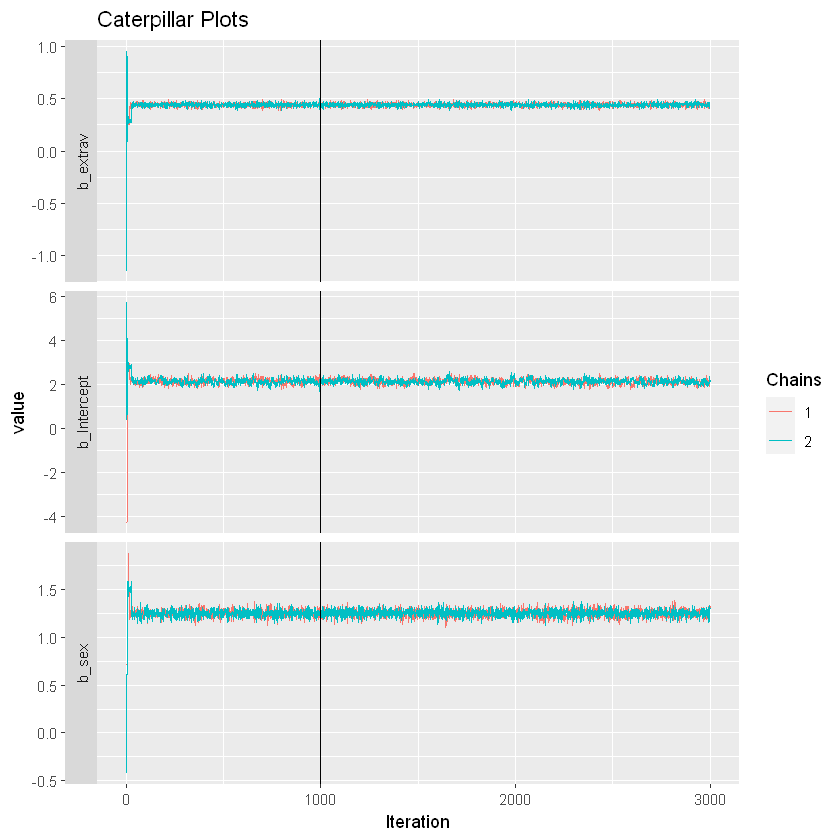

In [16]:
ggplot(filter(model1tranformed, Parameter %in% c("b_Intercept", "b_extrav", "b_sex")),
       aes(x   = Iteration,
           y   = value, 
           col = as.factor(Chain)))+
  geom_line() +
  geom_vline(xintercept = 1000)+
  facet_grid(Parameter ~ . ,
             scale  = 'free_y',
             switch = 'y')+
  labs(title = "Caterpillar Plots", 
       col   = "Chains")

También se puede observar como los coeficientes obtenidos no inlcuyen el valor 0.

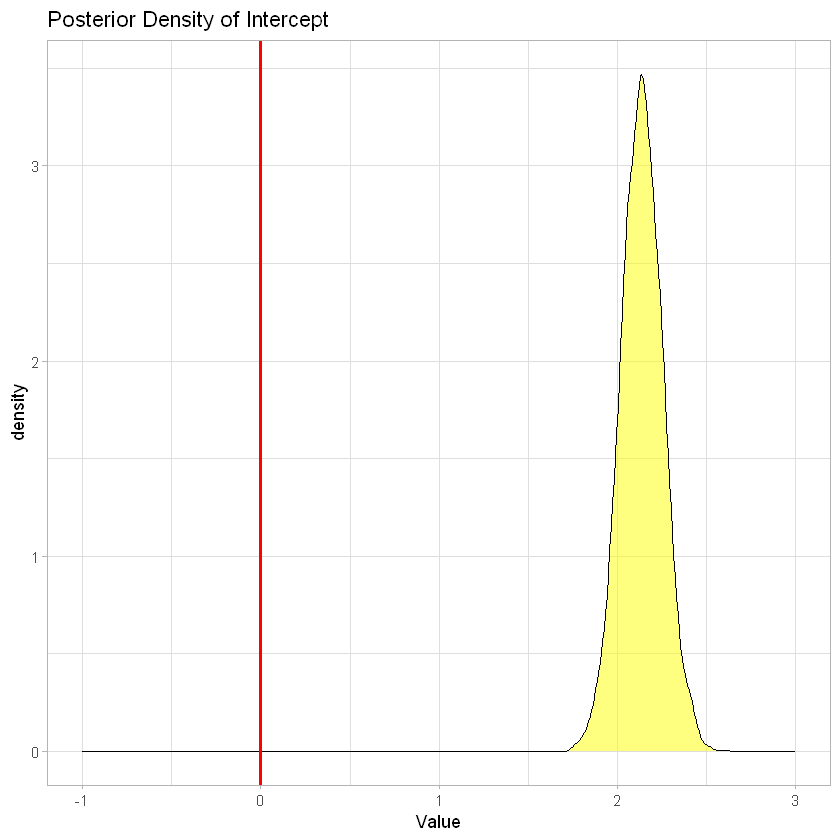

In [26]:
ggplot(filter(model1tranformed,Parameter == "b_Intercept", Iteration > 1000),aes(x = value))+
  geom_density(fill  = "yellow", alpha = .5)+
  geom_vline(xintercept = 0, col  = "red",size = 1)+
  scale_x_continuous(name   = "Value",limits = c(-1, 3)) + 
  #geom_vline(xintercept = summary(model1)$fixed[1,3:4],col = "blue",linetype = 2) +
  theme_light() +
  labs(title = "Posterior Density of Intercept")

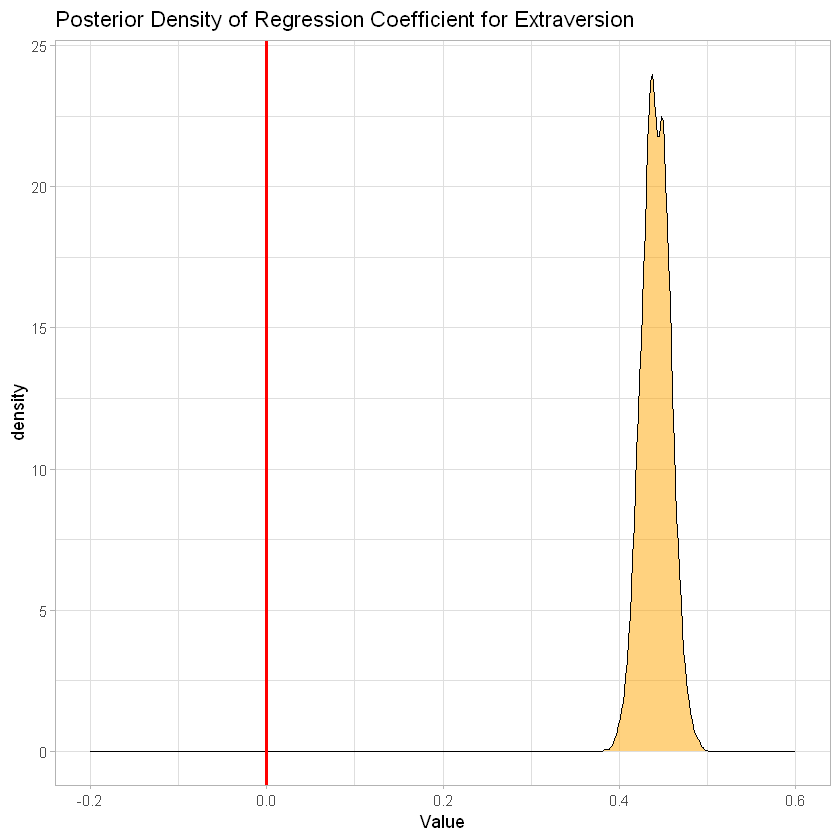

In [25]:
ggplot(filter(model1tranformed, Parameter == "b_extrav", Iteration > 1000), aes(x = value))+
  geom_density(fill = "orange", alpha = .5)+
  geom_vline(xintercept = 0, col = "red", size = 1)+
  scale_x_continuous(name = "Value", limits = c(-.2, .6))+ 
  #geom_vline(xintercept = summary(model1)$fixed[3,3:4], col = "blue", linetype = 2)+
  theme_light()+
  labs(title = "Posterior Density of Regression Coefficient for Extraversion")

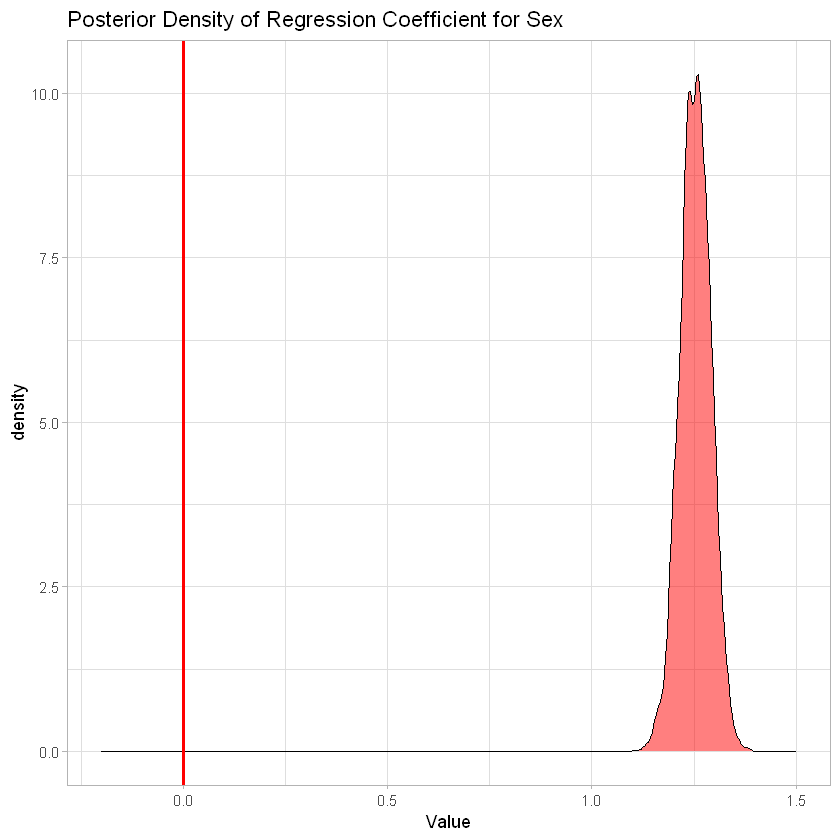

In [24]:
ggplot(filter(model1tranformed, Parameter == "b_sex", Iteration > 1000), aes(x = value))+
  geom_density(fill = "red", alpha = .5)+
  geom_vline(xintercept = 0, col = "red", size = 1)+
  scale_x_continuous(name = "Value", limits = c(-.2, 1.5))+ 
  #geom_vline(xintercept = summary(model1)$fixed[2,3:4], col = "blue", linetype = 2)+
  theme_light()+
  labs(title = "Posterior Density of Regression Coefficient for Sex")

## First and Second Level Predictors

Ahora se incluye una nueva variable predictora de segundo nivel, la experiencia del profesor *texp*.

In [27]:
model2 <- brm(popular ~ 1 + sex + extrav + texp + (1|class),  
              data = popular2data, 
              warmup = 1000, iter = 3000, 
              cores = 2, chains = 2, 
              seed = 123)
summary(model2)

Compiling Stan program...

Start sampling



 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: popular ~ 1 + sex + extrav + texp + (1 | class) 
   Data: popular2data (Number of observations: 2000) 
  Draws: 2 chains, each with iter = 3000; warmup = 1000; thin = 1;
         total post-warmup draws = 4000

Group-Level Effects: 
~class (Number of levels: 100) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.55      0.04     0.47     0.65 1.00      706     1080

Population-Level Effects: 
          Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept     0.80      0.17     0.47     1.13 1.00      576     1262
sex           1.25      0.04     1.18     1.33 1.00     3955     2782
extrav        0.45      0.02     0.42     0.49 1.00     4062     2854
texp          0.09      0.01     0.07     0.11 1.00      379      847

Family Specific Parameters: 
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sigma     0.77      0.01     0.75     0.79 

La varianza explicada en el nivel 1 y 2 se puede calcular de la siguiente manera:

Para nivel 1:

$
\frac{1.11^2-0.77^2}{1.11^2}=0.52
$

Para nivel 2:

$
\frac{0.85^2-0.55^2}{0.85^2}=0.58
$

## First and Second Level Predictors with Random Slopes (1)

Ahora vamos a incluir las pendientes aleatorias de las variables de primer nivel, *sex* y *extrav*.

In [28]:
model3 <- brm(popular ~ 1 + sex + extrav + (1 + sex + extrav | class),  
              data = popular2data, 
              warmup = 1000, iter = 3000, 
              cores = 2, chains = 2, 
              seed = 123) #to run the model

summary(model3)

Compiling Stan program...

Start sampling



 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: popular ~ 1 + sex + extrav + (1 + sex + extrav | class) 
   Data: popular2data (Number of observations: 2000) 
  Draws: 2 chains, each with iter = 3000; warmup = 1000; thin = 1;
         total post-warmup draws = 4000

Group-Level Effects: 
~class (Number of levels: 100) 
                      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS
sd(Intercept)             1.59      0.15     1.32     1.91 1.00     1188
sd(sex)                   0.08      0.05     0.00     0.19 1.00      882
sd(extrav)                0.17      0.02     0.13     0.22 1.01     1036
cor(Intercept,sex)       -0.19      0.43    -0.90     0.71 1.00     4613
cor(Intercept,extrav)    -0.92      0.03    -0.97    -0.87 1.00     1045
cor(sex,extrav)           0.05      0.44    -0.78     0.87 1.00      653
                      Tail_ESS
sd(Intercept)             2099
sd(sex)                   1524
sd(extrav)                1651
cor(Intercept,sex)    

El término del efecto para la variable *sex* es muy pequeño (0.08) lo que puede estar señalando que no es importante, por lo tanto se podria eliminar de los efectos aleatorios.

## First and Second Level Predictors with Random Slopes (2)

A continuación se elimina del modelo el factor aleatorio de la variable *sex*.

In [20]:
model4 <- brm(popular ~ 1 + sex + extrav + texp + (1 + extrav | class),  
              data = popular2data, 
              warmup = 1000, iter = 3000, 
              cores = 2, chains = 2, 
              seed = 123) #to run the model
summary(model4)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: popular ~ 1 + sex + extrav + texp + (1 + extrav | class)
   Data: popular2data

REML criterion at convergence: 4834.8

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.1768 -0.6475 -0.0235  0.6648  2.9684 

Random effects:
 Groups   Name        Variance Std.Dev. Corr 
 class    (Intercept) 1.30299  1.1415        
          extrav      0.03455  0.1859   -0.89
 Residual             0.55209  0.7430        
Number of obs: 2000, groups:  class, 100

Fixed effects:
             Estimate Std. Error        df t value Pr(>|t|)    
(Intercept) 7.361e-01  1.966e-01 1.821e+02   3.745 0.000242 ***
sex         1.252e+00  3.657e-02 1.913e+03  34.240  < 2e-16 ***
extrav      4.526e-01  2.461e-02 9.754e+01  18.389  < 2e-16 ***
texp        9.098e-02  8.685e-03 1.017e+02  10.475  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Correlation of Fixed Effects:
       (I

Otra forma de ver los resultados com mayor precisión es:

In [36]:
summary(model5)$fixed

,Estimate,Est.Error,l-95% CI,u-95% CI,Rhat,Bulk_ESS,Tail_ESS
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Intercept,-1.20843296,0.267871194,-1.71903453,-0.69213981,1.000719,2015.737,2689.506
sex,1.23968768,0.037524401,1.16638826,1.31364300,1.001389,5780.093,2644.709
extrav,0.80280051,0.038390913,0.72890888,0.87803241,1.000183,2940.505,2816.889
texp,0.22603841,0.016380743,0.19318182,0.25740225,1.000447,2059.763,2688.982
extrav:texp,-0.02467946,0.002426389,-0.02938955,-0.02007407,1.000371,3014.206,2739.519


In [37]:
summary(model5)$random

,Estimate,Est.Error,l-95% CI,u-95% CI,Rhat,Bulk_ESS,Tail_ESS
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
sd(Intercept),0.62022256,0.10627804,0.44830999,0.8612745,1.008899,386.5641,1611.6500
sd(extrav),0.04526119,0.03050573,0.00171387,0.1104312,1.031068,144.4182,612.6616
"cor(Intercept,extrav)",-0.38760458,0.41726229,-0.89800017,0.7419165,1.009856,785.5181,825.0519


## First and Second Level Predictors with Random Slopes and Crosslevel Interaction

Finalmente vamos a inccorporar en el análisis la interacción entre las variables *extrav* y *texp*

In [29]:
model5 <- brm(popular ~ 1 + sex + extrav + texp + extrav:texp + (1 + extrav|class), 
              data  = popular2data, warmup = 1000,
              iter  = 3000, chains = 2, 
              seed  = 123, control = list(adapt_delta = 0.97),
              cores = 2) # to reach a usuable number effective samples in the posterior distribution of the interaction effect, we need many more iteration. This sampler will take quite some time and you might want to run it with a few less iterations. 

summary(model5)

Compiling Stan program...

Start sampling

Warning message:
"Bulk Effective Samples Size (ESS) is too low, indicating posterior means and medians may be unreliable.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#bulk-ess"


 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: popular ~ 1 + sex + extrav + texp + extrav:texp + (1 + extrav | class) 
   Data: popular2data (Number of observations: 2000) 
  Draws: 2 chains, each with iter = 3000; warmup = 1000; thin = 1;
         total post-warmup draws = 4000

Group-Level Effects: 
~class (Number of levels: 100) 
                      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS
sd(Intercept)             0.62      0.11     0.45     0.86 1.01      387
sd(extrav)                0.05      0.03     0.00     0.11 1.03      144
cor(Intercept,extrav)    -0.39      0.42    -0.90     0.74 1.01      786
                      Tail_ESS
sd(Intercept)             1612
sd(extrav)                 613
cor(Intercept,extrav)      825

Population-Level Effects: 
            Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept      -1.21      0.27    -1.72    -0.69 1.00     2016     2690
sex             1.24      0.04     1.17     1.31 1.00 

Los resultados muestran que el intercepto y el coeficiente de *extrav* están influenciados ppor *texp*. Un estudiante hombre(sex=0) con un *extrv=0* en una clase con un profesor de 0 años de experiencia tiene una popularidad esperada de $-1.21317$, en el caso de una mujer tendria $0.80393$ por cada punto de *extrav*, cuando *texp* aumenta el intercepto incrementa en $0.22635$ por cada año de experiencia. Por lo tanto un estudainte hombre con *extrav=0* en una clase con un profesor de *texp=15*, tiene un popularidad de $-1.21317+(15*0.022635)=2.182$. Para un profesor con 15 años de experiencia, el coeficiente de regresión de *extrav* en popularidad es solamente $0.804-(15*0.0247)=0.4334$, comparado a 0.804 en una clase con un profesor con 0 años de experiencia.

En el siguiente gráfico tambián podemos ver que los años de experiencia tienen influencia en el intercepto y el coeficiente de regresión de *extrav* en la popularidad.

`geom_smooth()` using formula = 'y ~ x'


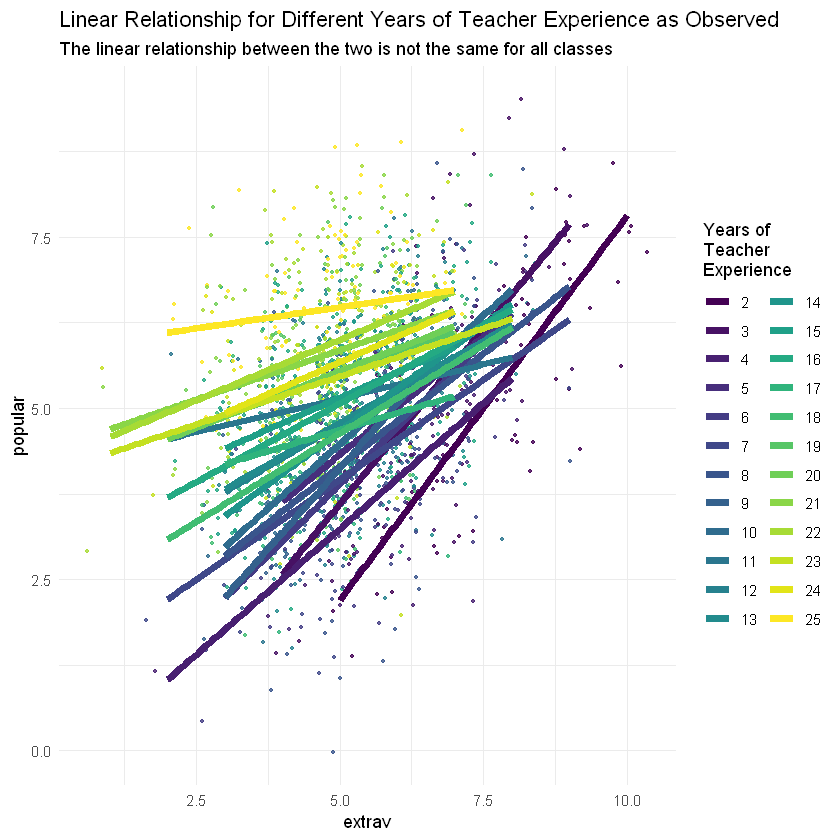

In [30]:
ggplot(data = popular2data, 
       aes(x   = extrav,
           y   = popular,
           col = as.factor(texp)))+
  viridis::scale_color_viridis(discrete = TRUE)+
  geom_point(size     = .7,
             alpha    = .8,
             position = "jitter")+
  geom_smooth(method = lm,
              se     = FALSE, 
              size   = 2,
              alpha  = .8)+
  theme_minimal()+
  labs(title    = "Linear Relationship for Different Years of Teacher Experience as Observed", 
       subtitle = "The linear relationship between the two is not the same for all classes", 
       col      = "Years of\nTeacher\nExperience")

In [31]:
simplemodel1 <- brm(popular ~ 1 + extrav + (1 + extrav | class), 
                  data = popular2data,
                  warmup = 1000, iter = 5000, chains = 2,  
                  seed = 123, control = list(adapt_delta = 0.96), 
                  save_all_pars = TRUE, cores= 2)


posteriorsimpelmodel1 <- as_tibble(t(posterior_samples(simplemodel1, pars = "extrav")[,-c(1:3)]))

teacherexperience <- popular2data %>%
  group_by(class) %>%
  summarise("teacherexperience" = mean(texp))

posteriorsimpelmodellong <- bind_cols(teacherexperience, posteriorsimpelmodel1) %>%
gather(key = "key", value = "value", -teacherexperience, -class)%>%
  group_by(class) %>%
  mutate(meanperclass = mean(value))%>%
  ungroup()

Warning message:
"Argument 'save_all_pars' is deprecated. Please use argument 'all' in function 'save_pars()' instead."
Compiling Stan program...

Start sampling

Warning message:
"There were 25 transitions after warmup that exceeded the maximum treedepth. Increase max_treedepth above 10. See
https://mc-stan.org/misc/warnings.html#maximum-treedepth-exceeded"
Warning message:
"Examine the pairs() plot to diagnose sampling problems
"
Warning message:
"Method 'posterior_samples' is deprecated. Please see ?as_draws for recommended alternatives."
Warning message:
"The `x` argument of `as_tibble.matrix()` must have unique column names if `.name_repair` is omitted as of tibble 2.0.0.
ℹ Using compatibility `.name_repair`."


Warning message:
"The dot-dot notation (`..density..`) was deprecated in ggplot2 3.4.0.
ℹ Please use `after_stat(density)` instead."
Picking joint bandwidth of 0.0121

Warning message:
"Removed 2158 rows containing non-finite values (`stat_density_ridges()`)."


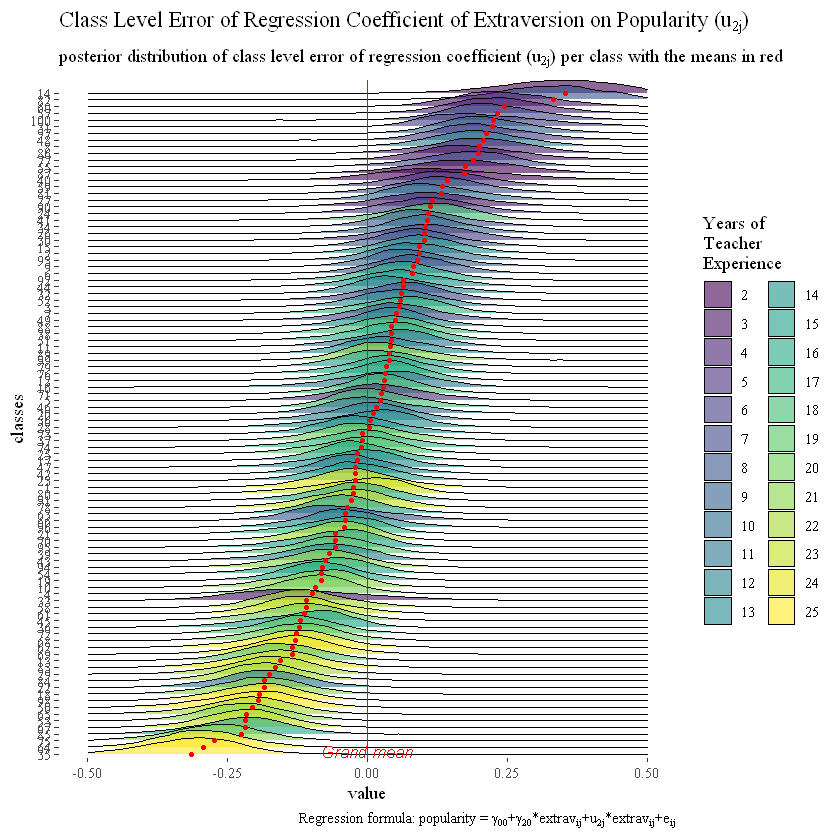

In [32]:
ggplot()+
  ggridges::geom_density_ridges(data  = posteriorsimpelmodellong, 
                                aes(x      = value,
                                    y      = reorder(as.factor(class), meanperclass),
                                    height = ..density.., 
                                    fill   = as.factor(teacherexperience)),
                                scale = 3, 
                                alpha = .6) +
  scale_x_continuous(limits = c(-.5,.5))+
  geom_point(data = summarise(group_by(posteriorsimpelmodellong, class), mean = mean(meanperclass)),
             aes(x = mean, 
                 y = as.factor(class)),
             size = 1, 
             col  = "red")+
  viridis::scale_fill_viridis(discrete = TRUE)+
  geom_vline(xintercept = 0, 
             col        = "red")+
  labs(fill     = "Years of\nTeacher\nExperience",
       y        = "classes", 
       title    = expression(paste("Class Level Error of Regression Coefficient of Extraversion on Popularity (", u["2j"],")")),
       subtitle = expression(paste("posterior distribution of class level error of regression coefficient (", u["2j"],") per class with the means in red")), 
       caption  = expression(paste("Regression formula: popularity = ", gamma["00"], "+", gamma["20"],"*", extrav["ij"], "+", u["2j"], "*", extrav["ij"],"+", e["ij"] )))+
  annotate(geom     = "text", 
           x        = 0, 
           y        = 1.5, 
           label    = "Grand mean", 
           col      = "red", 
           family   = theme_get()$text[["family"]], 
           size     = theme_get()$text[["size"]]/3, 
           fontface = "italic")+
  theme_tufte()

Esta figura muestra que las clases con profesores de menor experiencia es menos seguro el estimador de la desviación de la media debido a la varianza. Por lo tanto se puede mirar si existe una relación linear o cuadrática graficando la distancia entre e CCI para diferentes valores de experiencia. Los resutlados de esta gráfica confirman una relación cuadrática confirmando que los profesores con mayor experiencia tienen estimadores positivos del segundo nivel del término del error.

In [33]:
distance95 <- posteriorsimpelmodellong %>%
  group_by(class) %>%
  summarise(lower95      = quantile(value, probs = .025),
            upper95      = quantile(value, probs = .975),
            distance     = upper95-lower95, 
            Meanestimate = mean(value)) %>%
  bind_cols(teacherexperience)%>%
  group_by(teacherexperience)%>%
  summarise(mean         = mean(distance), 
            Meanestimate = mean(Meanestimate),
            lower        = mean(lower95), 
            upper        = mean(upper95),
            meanCCI      = paste("[",sprintf("%.4f",round(lower,4)), ":", sprintf("%.4f",round(upper,4)), "]")) 

distance95 <- mutate(distance95, Quadratic = teacherexperience^2)

model <- lm(mean ~ teacherexperience + Quadratic, data = distance95)

summary(model)

New names:
• `class` -> `class...1`
• `class` -> `class...6`



Call:
lm(formula = mean ~ teacherexperience + Quadratic, data = distance95)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.037463 -0.006439  0.000555  0.006556  0.041157 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)        4.406e-01  1.299e-02  33.921  < 2e-16 ***
teacherexperience -1.159e-02  2.197e-03  -5.277 3.12e-05 ***
Quadratic          3.170e-04  7.931e-05   3.997 0.000654 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.01661 on 21 degrees of freedom
Multiple R-squared:  0.7212,	Adjusted R-squared:  0.6946 
F-statistic: 27.16 on 2 and 21 DF,  p-value: 1.499e-06


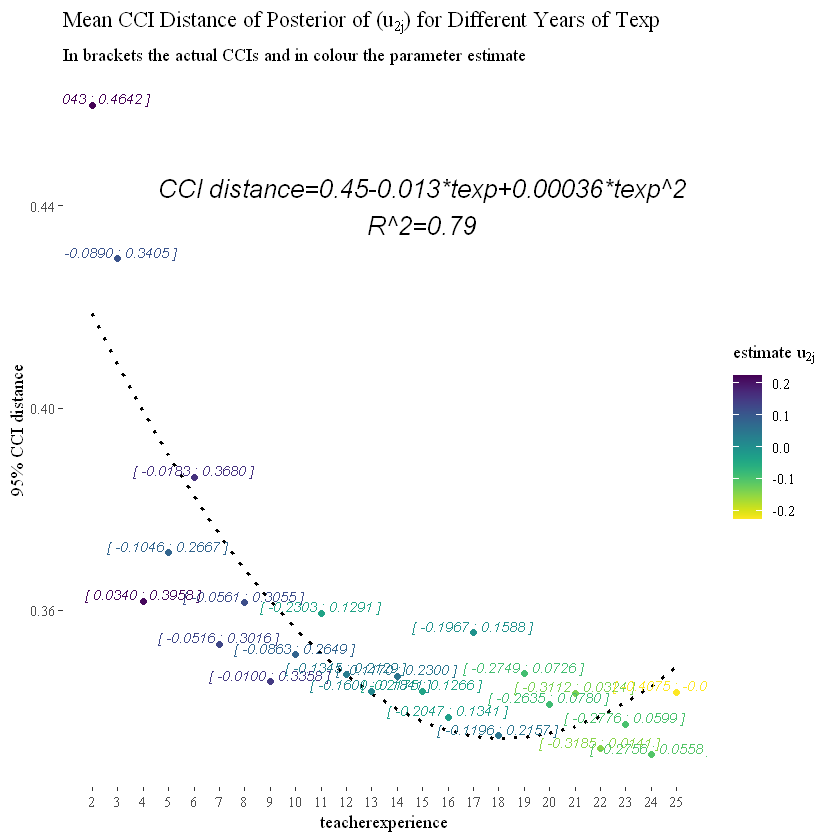

In [34]:
dat <- data.frame(teacherexperience = c(2:25),
                  Quadratic         = c(2:25)^2)

dat$yhat <- predict(model, dat)

ggplot()+
  geom_line(data  = dat, 
            aes(x = teacherexperience,
                y = yhat), 
            linetype = "dotted",
            size     = 1)+
  geom_point(data = distance95, 
             aes(x   = teacherexperience, 
                 y   = mean, 
                 col = Meanestimate))+
  geom_text(data  = distance95, 
            aes(x     = teacherexperience, 
                y     = mean, 
                label = meanCCI,
                col   = Meanestimate),
            hjust    = .5, 
            vjust    = -.15, 
            family   = theme_get()$text[["family"]], 
            size     = 3, 
            fontface = "italic")+
  annotate(geom = "text", 
           x    = 15, 
           y    = 0.44,
           label    = "CCI distance=0.45-0.013*texp+0.00036*texp^2\nR^2=0.79", 
           colour   = "black",  
           family   = theme_get()$text[["family"]], 
           size     = theme_get()$text[["size"]]/2, 
           fontface = "italic")+
  viridis :: scale_color_viridis(discrete = F, direction = -1)+
  labs(y        = "95% CCI distance",
       title    = expression(paste("Mean CCI Distance of Posterior of (", u["2j"], ") for Different Years of Texp")),
       subtitle = "In brackets the actual CCIs and in colour the parameter estimate",
       col      = expression(paste("estimate ", u["2j"])))+
  scale_x_continuous(breaks = 2:25)+
  theme_tufte()


## The Effect of Priors

Para obtener los *priors* con que corrió el modelo utilizamos el siguiente código:

In [38]:
get_prior(popular ~ 0 + intercept + sex + extrav + texp + extrav:texp + (1 + extrav | class), data = popular2data)

Warning message:
"Reserved variable name 'intercept' is deprecated. Please use 'Intercept' instead."


prior,class,coef,group,resp,dpar,nlpar,lb,ub,source
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
,b,,,,,,,,default
,b,extrav,,,,,,,default
,b,extrav:texp,,,,,,,default
,b,intercept,,,,,,,default
,b,sex,,,,,,,default
,b,texp,,,,,,,default
lkj(1),cor,,,,,,,,default
,cor,,class,,,,,,default
"student_t(3, 0, 2.5)",sd,,,,,,0,,default


Para incluir nuestros *priors*, de acuerdo con el conocimiento de las variables que tengamos, se realiza de la siguiente forma:

In [39]:
prior1 <- c(set_prior("normal(-10,100)", class = "b", coef = "extrav"),
            set_prior("normal(10,100)", class = "b", coef = "extrav:texp"),
            set_prior("normal(-5,100)", class = "b", coef = "sex"),
            set_prior("normal(-5,100)", class = "b", coef = "texp"),
            set_prior("normal(10,100)", class = "b", coef = "intercept" ))

In [40]:
model6 <- brm(popular ~ 0 + intercept + sex + extrav + texp + extrav:texp + (1 + extrav|class), 
              data  = popular2data, warmup = 1000,
              iter  = 3000, chains = 2, 
              prior = prior1,
              seed  = 123, control = list(adapt_delta = 0.97),
              cores = 2,
              sample_prior = TRUE) # to reach a usuable number effective samples in the posterior distribution of the interaction effect, we need many more iteration. This sampler will take quite some time and you might want to run it with a few less iterations.

prior_summary(model6)

Warning message:
"Reserved variable name 'intercept' is deprecated. Please use 'Intercept' instead."
Compiling Stan program...

Start sampling

Warning message:
"Bulk Effective Samples Size (ESS) is too low, indicating posterior means and medians may be unreliable.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#bulk-ess"


prior,class,coef,group,resp,dpar,nlpar,lb,ub,source
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
,b,,,,,,,,default
"normal(-10,100)",b,extrav,,,,,,,user
"normal(10,100)",b,extrav:texp,,,,,,,user
"normal(10,100)",b,intercept,,,,,,,user
"normal(-5,100)",b,sex,,,,,,,user
"normal(-5,100)",b,texp,,,,,,,user
lkj_corr_cholesky(1),L,,,,,,,,default
,L,,class,,,,,,default
"student_t(3, 0, 2.5)",sd,,,,,,0,,default


In [ ]:
stancode(model6)

In [52]:
prior2 <- c(set_prior("normal(.8,.1)", class = "b", coef = "extrav"),
            set_prior("normal(-.025,.1)", class = "b", coef = "extrav:texp"),
            set_prior("normal(1.25,.1)", class = "b", coef = "sex"),
            set_prior("normal(.23,.1)", class = "b", coef = "texp"),
            set_prior("normal(-1.21,.1)", class = "b", coef = "intercept" ))

model7 <- brm(popular ~ 0 + Intercept + sex + extrav + texp + extrav:texp + (1 + extrav|class), 
              data  = popular2data, warmup = 1000,
              iter  = 3000, chains = 2, 
              prior = prior2,
              seed  = 123, control = list(adapt_delta = 0.97),
              cores = 2,
              sample_prior = TRUE)

summary(model7)

Warning message:
"Reserved variable name 'intercept' is deprecated. Please use 'Intercept' instead."
Compiling Stan program...

Start sampling

Warning message:
"There were 1 transitions after warmup that exceeded the maximum treedepth. Increase max_treedepth above 10. See
https://mc-stan.org/misc/warnings.html#maximum-treedepth-exceeded"
Warning message:
"Examine the pairs() plot to diagnose sampling problems
"
Warning message:
"Bulk Effective Samples Size (ESS) is too low, indicating posterior means and medians may be unreliable.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#bulk-ess"


 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: popular ~ 0 + intercept + sex + extrav + texp + extrav:texp + (1 + extrav | class) 
   Data: popular2data (Number of observations: 2000) 
  Draws: 2 chains, each with iter = 3000; warmup = 1000; thin = 1;
         total post-warmup draws = 4000

Group-Level Effects: 
~class (Number of levels: 100) 
                      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS
sd(Intercept)             0.63      0.11     0.45     0.87 1.00      393
sd(extrav)                0.05      0.03     0.00     0.11 1.02      152
cor(Intercept,extrav)    -0.42      0.38    -0.87     0.66 1.00     1142
                      Tail_ESS
sd(Intercept)             1957
sd(extrav)                 595
cor(Intercept,extrav)     1013

Population-Level Effects: 
            Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
intercept      -1.21      0.09    -1.39    -1.03 1.00     4153     2920
sex             1.24      0.04     1.17   

In [53]:
prior3 <- c(set_prior("normal(-1,.1)", class = "b", coef = "extrav"),
            set_prior("normal(3, 1)", class = "b", coef = "extrav:texp"),
            set_prior("normal(-3,1)", class = "b", coef = "sex"),
            set_prior("normal(-3,1)", class = "b", coef = "texp"),
            set_prior("normal(0,5)", class = "b", coef = "intercept" ))

model8 <- brm(popular ~ 0 + Intercept + sex + extrav + texp + extrav:texp + (1 + extrav|class), 
              data  = popular2data, warmup = 1000,
              iter  = 3000, chains = 2, 
              prior = prior3,
              seed  = 123, control = list(adapt_delta = 0.97),
              cores = 2,
              sample_prior = TRUE)

summary(model8)

Warning message:
"Reserved variable name 'intercept' is deprecated. Please use 'Intercept' instead."
Compiling Stan program...

Start sampling

Warning message:
"There were 168 transitions after warmup that exceeded the maximum treedepth. Increase max_treedepth above 10. See
https://mc-stan.org/misc/warnings.html#maximum-treedepth-exceeded"
Warning message:
"Examine the pairs() plot to diagnose sampling problems
"


 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: popular ~ 0 + intercept + sex + extrav + texp + extrav:texp + (1 + extrav | class) 
   Data: popular2data (Number of observations: 2000) 
  Draws: 2 chains, each with iter = 3000; warmup = 1000; thin = 1;
         total post-warmup draws = 4000

Group-Level Effects: 
~class (Number of levels: 100) 
                      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS
sd(Intercept)             2.15      0.40     1.43     2.94 1.01      270
sd(extrav)                0.40      0.07     0.26     0.54 1.02      243
cor(Intercept,extrav)    -0.96      0.02    -0.98    -0.92 1.01      280
                      Tail_ESS
sd(Intercept)              611
sd(extrav)                 460
cor(Intercept,extrav)      695

Population-Level Effects: 
            Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
intercept       3.59      0.90     1.88     5.28 1.02      269      694
sex             1.25      0.04     1.18   

Como se puede observar este modelo no modifica en gran medida el modelo con los *priors* definido por defecto por *brms*. Vamos a hora a utilizar unos *priors* adecuados y obtenidos por conocimiento previo del problema.

In [42]:
prior4 <- c(set_prior("normal(3,.1)", class = "b", coef = "extrav"),
            set_prior("normal(-3,1)", class = "b", coef = "extrav:texp"),
            set_prior("normal(3,1)", class = "b", coef = "sex"),
            set_prior("normal(3,1)", class = "b", coef = "texp"),
            set_prior("normal(0,5)", class = "b", coef = "intercept" ))


model9 <- brm(popular ~ 0 + intercept + sex + extrav + texp + extrav:texp + (1 + extrav|class), 
              data  = popular2data, warmup = 1000,
              iter  = 3000, chains = 2, 
              prior = prior4,
              seed  = 123, control = list(adapt_delta = 0.97),
              cores = 2,
              sample_prior = TRUE)

summary(model9)

Warning message:
"Reserved variable name 'intercept' is deprecated. Please use 'Intercept' instead."
Compiling Stan program...

Start sampling

Warning message:
"There were 10 transitions after warmup that exceeded the maximum treedepth. Increase max_treedepth above 10. See
https://mc-stan.org/misc/warnings.html#maximum-treedepth-exceeded"
Warning message:
"Examine the pairs() plot to diagnose sampling problems
"


 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: popular ~ 0 + intercept + sex + extrav + texp + extrav:texp + (1 + extrav | class) 
   Data: popular2data (Number of observations: 2000) 
  Draws: 2 chains, each with iter = 3000; warmup = 1000; thin = 1;
         total post-warmup draws = 4000

Group-Level Effects: 
~class (Number of levels: 100) 
                      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS
sd(Intercept)             3.45      0.42     2.67     4.33 1.00      452
sd(extrav)                0.67      0.07     0.54     0.82 1.01      575
cor(Intercept,extrav)    -0.99      0.00    -0.99    -0.98 1.00      499
                      Tail_ESS
sd(Intercept)              788
sd(extrav)                1158
cor(Intercept,extrav)     1144

Population-Level Effects: 
            Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
intercept      -9.34      0.79   -10.95    -7.85 1.00      460      973
sex             1.25      0.04     1.18   

Se pueden obtener las siguientes gráficas de las probabilidades posteriores:

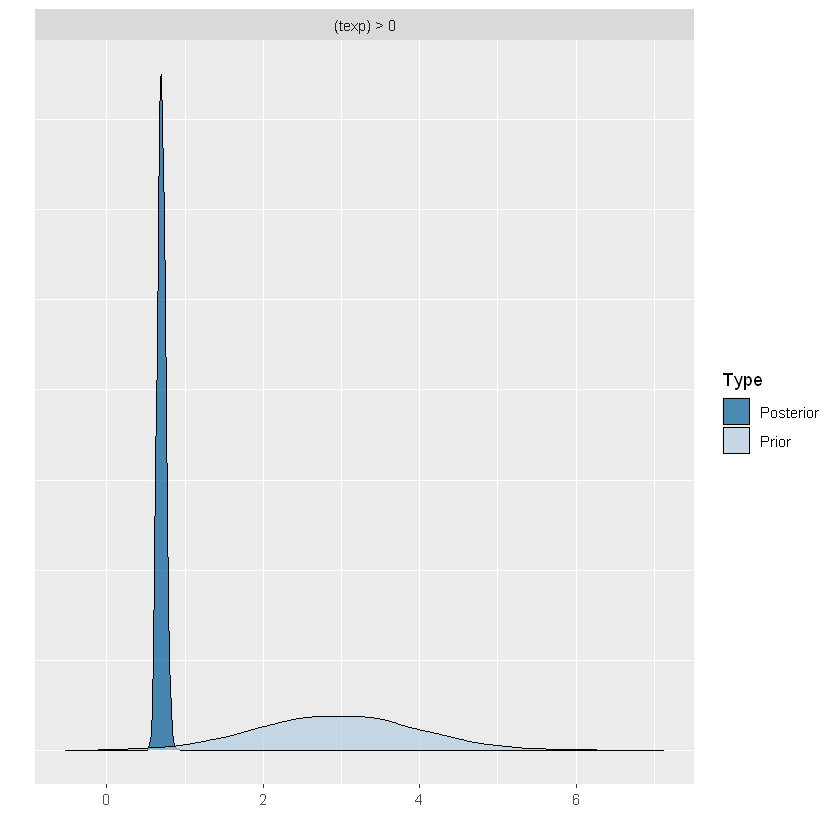

In [46]:
plot(hypothesis(model9, "texp > 0")) # if you would just run this command without the plot wrapper, you would get the support for the hypothesis that the regression coefficient texp is larger than 0, this is in interesting way to test possible hypothesis you had.

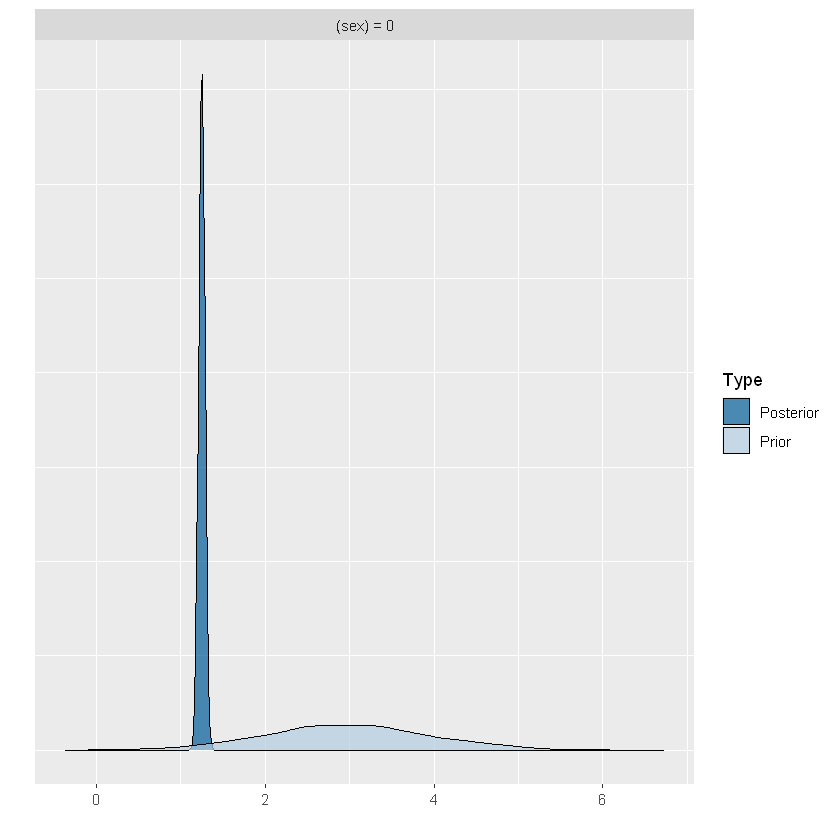

In [47]:
plot(hypothesis(model9, "sex = 0"))

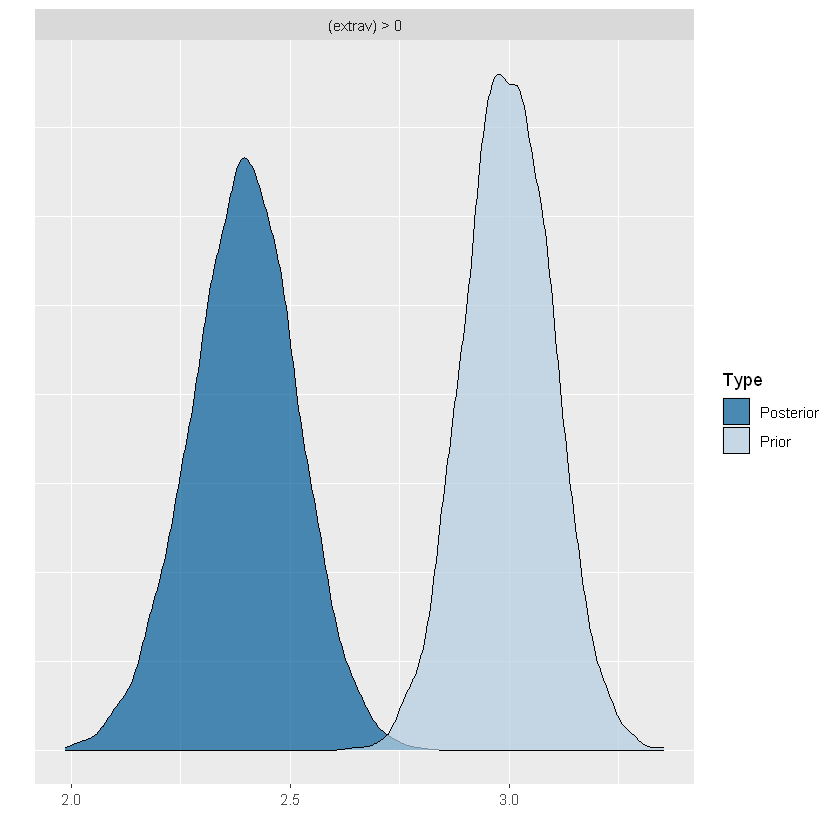

In [48]:
plot(hypothesis(model9, "extrav > 0"))

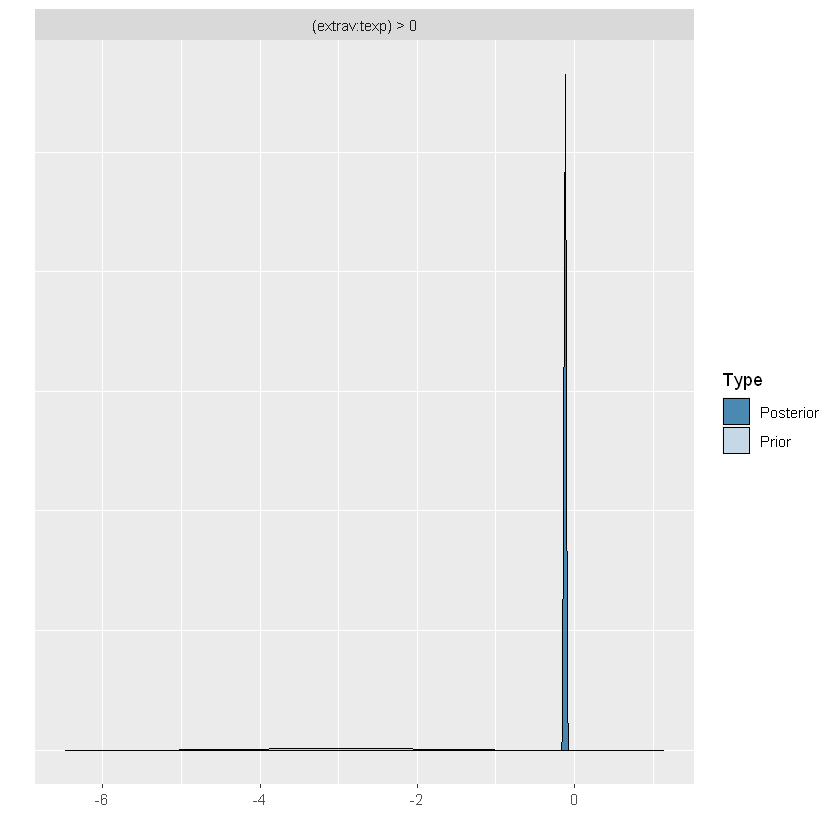

In [49]:
plot(hypothesis(model9, "extrav:texp > 0"))

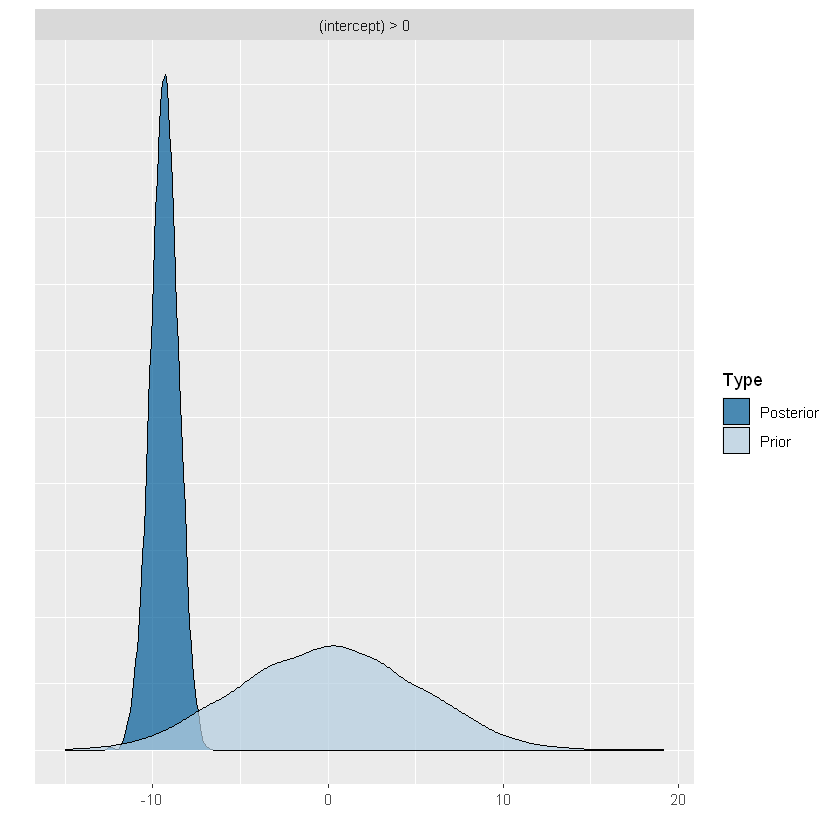

In [50]:
plot(hypothesis(model9, "intercept > 0"))

Warning message:
"Method 'posterior_samples' is deprecated. Please see ?as_draws for recommended alternatives."
Warning message:
"Method 'posterior_samples' is deprecated. Please see ?as_draws for recommended alternatives."
Warning message:
"Method 'posterior_samples' is deprecated. Please see ?as_draws for recommended alternatives."
Warning message:
"Using alpha for a discrete variable is not advised."
Warning message:
"Removed 5900 rows containing non-finite values (`stat_density()`)."


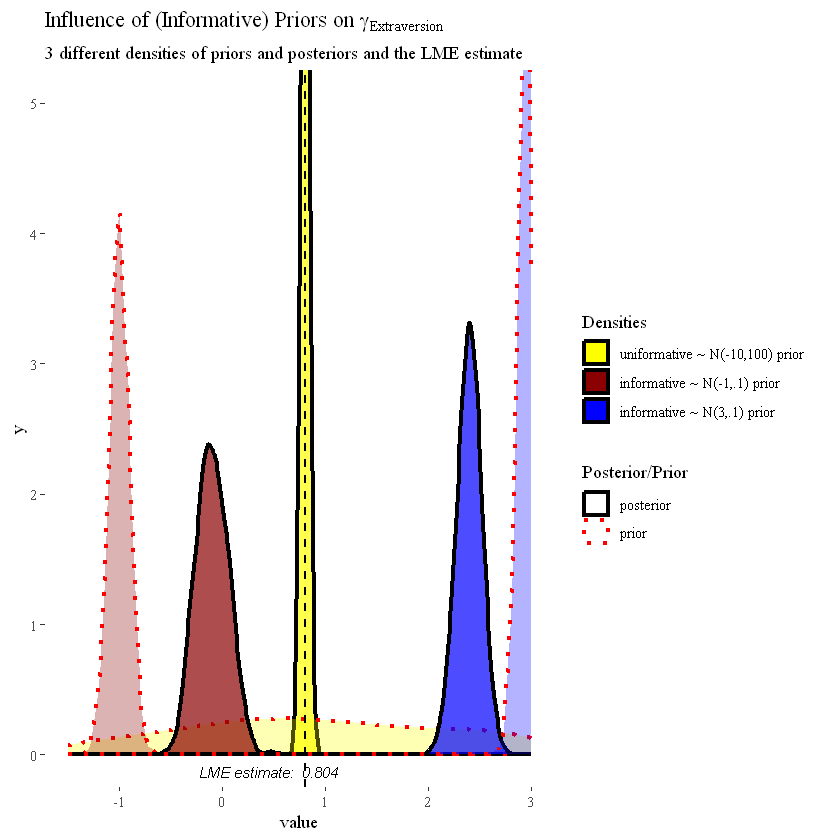

In [56]:
posterior1 <- posterior_samples(model6, pars = "b_extrav")[, c(1,3)]
posterior2 <- posterior_samples(model8, pars = "b_extrav")[, c(1,3)]
posterior3 <- posterior_samples(model9, pars = "b_extrav")[, c(1,3)]

posterior1.2.3 <- bind_rows("prior 1" = gather(posterior1),
                            "prior 2" = gather(posterior2), 
                            "prior 3" = gather(posterior3), 
                            .id = "id")
modelLME <- lmer(popular ~ 1 + sex + extrav + texp + extrav:texp + (1 + extrav | class), data = popular2data)

ggplot(data    = posterior1.2.3, 
       mapping = aes(x        = value,
                     fill     =  id, 
                     colour   = key,
                     linetype = key, 
                     alpha    = key)) +
  geom_density(size = 1.2)+
  geom_vline(xintercept = summary(modelLME)$coefficients["extrav", "Estimate"], # add the frequentist solution too
             size = .8, linetype = 2, col = "black")+ 
  scale_x_continuous(limits = c(-1.5, 3))+
  coord_cartesian(ylim = c(0, 5))+
  scale_fill_manual(name   = "Densities", 
                    values = c("Yellow","darkred","blue" ), 
                    labels = c("uniformative ~ N(-10,100) prior",
                               "informative ~ N(-1,.1) prior",
                               "informative ~ N(3,.1) prior") )+
  scale_colour_manual(name   = 'Posterior/Prior', 
                      values = c("black","red"), 
                      labels = c("posterior", "prior"))+
  scale_linetype_manual(name   ='Posterior/Prior', 
                        values = c("solid","dotted"), 
                        labels = c("posterior", "prior"))+
  scale_alpha_discrete(name   = 'Posterior/Prior', 
                       range  = c(.7,.3), 
                       labels = c("posterior", "prior"))+
  annotate(geom    = "text", 
           x = 0.45, y = -.13,
           label  = "LME estimate:  0.804", 
           col    = "black", 
           family = theme_get()$text[["family"]], 
           size   = theme_get()$text[["size"]]/3.5, 
           fontface="italic")+
  labs(title    = expression("Influence of (Informative) Priors on" ~ gamma[Extraversion]),
       subtitle = "3 different densities of priors and posteriors and the LME estimate")+
  theme_tufte()


## WAMBS checklist
### 
When to worry, and how to Avoid the Misuse of Bayesian Statistics

1. To be checked before estimating the model

Do you understand the prior

s3. ?
To be checked after estimation but before inspecting model resuls

Does the trace-plot exhibit converg, nce?
Does convergence remain after doubling the number of itera, ions?
Does the posterior distribution histogram have enough infor, ation?
Do the chains exhibit a strong degree of autocorr, lation?
Do the posterior distributions make substanti

v5. e sense?
Understanding the exact influence of te priors

Do different specification of the multivariate variance priors influence , he results?
Is there a notable effect of the prior when compared with non-inform, tive priors?
Are the results stable from a sensiti, ity analysis?
Is the Bayesian way of interpreting and reporting mode.l results used?

#### Does the trace-plot exhibit convergence?

In [ ]:
modeltranformed <- ggs(model) # the ggs function transforms the BRMS output into a longformat tibble, that we can use to make different types of plots.


In [ ]:
ggplot(filter(modeltranformed, Parameter %in% c("b_intercept", "b_extrav", "b_sex", "b_extrav:texp", "b_texp", "sigma"),
              Iteration > 1000),
       aes(x   = Iteration,
           y   = value, 
           col = as.factor(Chain)))+
  geom_line()+
  facet_grid(Parameter ~ .,
             scale  = 'free_y',
             switch = 'y')+
  labs(title = "Caterpillar Plots",
       col   = "Chains")

In [ ]:
stanplot(model, type = "trace")

We can check if the chains convergenced by having a look at the convergence diagnostics. Two of these diagnostics of interest include the Gelman and Rubin diagnostic and the Geweke diagnostic.

The Gelman-Rubin Diagnostic shows the PSRF values (using the within and between chain variability). You should look at the Upper CI/Upper limit, which are all should be close to 1. If they aren’t close to 1, you should use more iterations. Note: The Gelman and Rubin diagnostic is also automatically given in the summary of brms under the column Rhat
The Geweke Diagnostic shows the z-scores for a test of equality of means between the first and last parts of each chain, which should be <1.96. A separate statistic is calculated for each variable in each chain. In this way it check whether a chain has stabalized. If this is not the case, you should increase the number of iterations. In the plots you should check how often values exceed the boundary lines of the z-scores. Scores above 1.96 or below -1.96 mean that the two portions of the chain significantly differ and full chain convergence was not obtained.
To obtain the Gelman and Rubin diagnostic use:

In [ ]:
modelposterior <- as.mcmc(model) # with the as.mcmc() command we can use all the CODA package convergence statistics and plotting options
gelman.diag(modelposterior[, 1:5])

In [ ]:
gelman.plot(modelposterior[, 1:5])

To obtain the Geweke diagnostic use:

geweke.diag(modelposterior[, 1:5])

In [ ]:
geweke.plot(modelposterior[, 1:5])

Now we see that the Gelman and Rubin diagnostic (PRSF) is close to 1 for all parameters and the the Geweke diagnostic is not > 1.96.

#### Does convergence remain after doubling the number of iterations?

As is recommended in the WAMBS checklist, we double the amount of iterations to check for local convergence.

In [ ]:
modeldoubleniter <- brm(popular ~ 0 + intercept + sex + extrav + texp + extrav:texp + (1 + extrav|class), 
            data          = popular2data,
            warmup        = 2000, 
            iter          = 6000,
            chains        = 3, 
            control       = list(adapt_delta = 0.96), 
            prior         = PRIORS,
            save_all_pars = TRUE,
            sample_prior  = TRUE,
            cores         = 3, # the cores function tells STAN to make use of 3 CPU cores simultaneously instead of just 1.
            seed          = 123) 

In [ ]:
modeldoubleniterposterior <- as.mcmc(modeldoubleniter)
modelposterior <- as.mcmc(model) # with the as.mcmc() command we can use all the CODA package convergence statistics and plotting options
gelman.diag(modeldoubleniterposterior[, 1:5])

In [ ]:
gelman.plot(modeldoubleniterposterior[, 1:5])

You should again have a look at the above-mentioned convergence statistics, but we can also compute the relative bias to inspect if doubling the number of iterations influences the posterior parameter estimates (\(bias= 100*\frac{(model \; with \; double \; iteration \; – \; initial \; converged \; model )}{initial \; converged \; model}\)). In order to preserve clarity we just calculate the bias of the two regression coefficients.
You should combine the relative bias in combination with substantive knowledge about the metric of the parameter of interest to determine when levels of relative deviation are negligible or problematic. For example, with a regression coefficient of 0.001, a 5% relative deviation level might not be substantively relevant. However, with an intercept parameter of 50, a 10% relative deviation level might be quite meaningful. The specific level of relative deviation should be interpreted in the substantive context of the model. Some examples of interpretations are:

if relative deviation is < |5|%, then do not worry;
if relative deviation > |5|%, then rerun with 4x nr of iterations.

In [ ]:
round(100*((summary(modeldoubleniter)$fixed - summary(model)$fixed) / summary(model)$fixed), 3)[,"Estimate"]

The relative bias is small enough (<5%) not worry about it



#### Does the posterior distribution histogram have enough information?

By having a look at the postrior distribution density (or if you like histogram) we can check if it has enough information. For regression coefficients it ideally it is clearly centerered with smooth sloping tails.

In [ ]:
stanplot(model, type = "hist")

The different posterior distributions have enough information and more iterations are not necessary. They are all single peaked with smooth slopes. Posterior distributions do not have to be symmetrical, but in this example they seem to be.

#### Do the chains exhibit a strong degree of autocorrelation?

In [ ]:
autocorr.diag(modelposterior[,1:5], lags = c(0, 1,2,3,4, 5, 10, 50))

These results show that autocorrelation is quite stong after a few lags. This means it is important to make sure we ran the analysis with a lot of samples, because with a high autocorrelation it will take longer until the whole parameter space has been identified. 

#### Do the posterior distributions make substantive sense?

In [ ]:
ggplot(filter(modeltranformed, Parameter %in% c("b_intercept", "b_extrav","b_sex"), 
              Iteration > 1000),
       aes(x    = value,
           fill = Parameter))+
  geom_density(alpha = .5)+
  geom_vline(xintercept = 0,
             col        = "red",
             size       = 1)+
  scale_x_continuous(name   = "Value",
                     limits = c(-2.2, 1.5))+ 
    geom_vline(xintercept = summary(model)$fixed[1,3:4], col = "darkgreen", linetype = 2)+
    geom_vline(xintercept = summary(model)$fixed[2,3:4], col = "blue",      linetype = 2)+
    geom_vline(xintercept = summary(model)$fixed[3,3:4], col = "red",       linetype = 2)+
  theme_light()+
   scale_fill_manual(name   =  'Parameters', 
                     values = c("red","darkgreen" , "lightblue"), 
                     labels = c(expression( " "  ~  gamma[Exraversion]), 
                                expression( " "  ~  gamma[Intercept]),  
                                expression( " "  ~  gamma[Sex])))+
  labs(title = "Posterior Density of Parameters With 95% CCI lines (1)")

In [ ]:
ggplot(filter(modeltranformed, 
              Parameter %in% c("b_texp","b_extrav:texp"),
              Iteration > 1000),
       aes(x    = value,
           fill = Parameter))+
  geom_density(alpha = .5)+
  geom_vline(xintercept = 0, 
             col        = "red", 
             size       = 1)+
  coord_cartesian(ylim = c(0, 25))+
    geom_vline(xintercept = summary(model)$fixed[4,3:4], col = "purple", linetype = 2)+
    geom_vline(xintercept = summary(model)$fixed[5,3:4], col = "red",    linetype = 2)+
  theme_light()+
     scale_fill_manual(name   = 'Parameters', 
                       values = c("Darkred","purple"), 
                       labels = c(expression( " "  ~  gamma[extrav:texp]), 
                                  expression( " "  ~  gamma[ texp])))+
  labs(title = "Posterior Density of Parameters With 95% CCI lines (2)")

In [ ]:
stanplot(model, pars = 1:4, type = "dens")

#### Do different specification of the multivariate variance priors influence the results?

In [ ]:
PRIORS2 <- c(set_prior("normal(0,5)", class = "b", coef= "extrav"),
            set_prior("normal(-1,.3)", class = "b", coef= "extrav:texp"),
            set_prior("normal(2,.2)", class = "b", coef= "sex"),
            set_prior("normal(0,5)", class = "b", coef= "texp"),
            set_prior("cauchy(0,10)",  class = "b", coef = "intercept" ),
            set_prior("cauchy(0,2)", class = "sd"),          # a half cauchy distribution (truncuated at 0) for the sd
            set_prior("lkj(2)", class = "cor"),              # a Cholesky of 2 for the correlation  
            set_prior("inv_gamma(.5,.5)", class = "sigma")) # an uniformative inverse gamma for the sigma. 


modeldifferentMVpriors <- brm(popular ~ 0 + intercept + sex + extrav + texp + extrav:texp + (1 + extrav|class), 
            data          = popular2data,
            warmup        = 1000, 
            iter          = 3000,
            chains        = 3, 
            control       = list(adapt_delta = 0.96), 
            prior         = PRIORS2,
            save_all_pars = TRUE,
            sample_prior  = TRUE,
            cores         = 3, # the cores function tells STAN to make use of 3 CPU cores simultaneously instead of just 1.
            seed          = 123) 

summary(modeldifferentMVpriors)

We see that these new priors had little influence on the estimation of the regression coefficients, but we do see that the sds got smaller. This is because the half cauchy prior we used is weakly informative towards 0 compared to the default priors. Also, because we set the correlation prior quite a bit higher we get a lower estimated correlation between the random effects. To quantify these differences, we can also calculate the biases again.

round(100*((summary(modeldifferentMVpriors)$fixed - summary(model)$fixed) / summary(model)$fixed), 3)[,"Estimate"]


#### Is there a notable effect of the prior when compared with non-informative priors?

One might be interested in re-runinng the analysis, but with uninformartive priors simply to check if these priors had a large influence on the estimates. A large influence of informative prior is not per se problematic (even one of the strengths of a Bayesian analysis), but unlikely in a large dataset such as this one. We can specify priors as we did before, using the prior command in the brm() function.

In [ ]:
PRIORSUNIFORMATIVE <- c(set_prior("normal(0,100)", class = "b", coef= "extrav"),
            set_prior("normal(0,100)", class = "b", coef= "extrav:texp"),
            set_prior("normal(0,100)", class = "b", coef= "sex"),
            set_prior("normal(0,100)", class = "b", coef= "texp"),
            set_prior("cauchy(0,10)",  class = "b", coef = "intercept"))

modeluninformativepriors<- brm(popular ~ 0 + intercept + sex + extrav + texp + extrav:texp + (1 + extrav|class), 
            data          = popular2data,
            warmup        = 1000, 
            iter          = 3000,
            chains        = 3, 
            control       = list(adapt_delta = 0.96), 
            prior         = PRIORSUNIFORMATIVE,
            save_all_pars = TRUE,
            sample_prior  = TRUE,
            cores         = 3, # the cores function tells STAN to make use of 3 CPU cores simultaneously instead of just 1.
            seed          = 123) 

summary(modeluninformativepriors)


We see only a small difference between the informative and uninformative priors. We see that the estimates are ‘pulled’ toward the mean of the informative priors we specified for the regression coefficients of sex and extrav:texp.
We can also calculate a relative biases again. With the exception of the regression coefficient for sex, all estimated biases are less than 1%.

In [ ]:
round(100*((summary(modeluninformativepriors)$fixed - summary(model)$fixed) / summary(model)$fixed), 3)[,"Estimate"]


####  Are the results stable from a sensitivity analysis?

If you still have time left, you can adjust the hyperparameters of the priors upward and downward and re-estimating the model with these varied priors to check for robustness.
From the original paper:

“If informative or weakly-informative priors are used, then we suggest running a sensitivity analysis of these priors. When subjective priors are in place, then there might be a discrepancy between results using different subjective prior settings. A sensitivity analysis for priors would entail adjusting the entire prior distribution (i.e., using a completely different prior distribution than before) or adjusting hyperparameters upward and downward and re-estimating the model with these varied priors. Several different hyperparameter specifications can be made in a sensitivity analysis, and results obtained will point toward the impact of small fluctuations in hyperparameter values. [.] The purpose of this sensitivity analysis is to assess how much of an impact the location of the mean hyperparameter for the prior has on the posterior. [.] Upon receiving results from the sensitivity analysis, assess the impact that fluctuations in the hyperparameter values have on the substantive conclusions. Results may be stable across the sensitivity analysis, or they may be highly instable based on substantive conclusions. Whatever the finding, this information is important to report in the results and discussion sections of a paper. We should also reiterate here that original priors should not be modified, despite the results obtained.”

####  Is the Bayesian way of interpreting and reporting model results used?